In [14]:
# imports
from copy import deepcopy
import numpy as np

from sklearn.utils import shuffle

import sys
sys.path.append('../src/')

from classification import get_basis
from evaluation import central_loss, central_accuracy
from network import synthetic_graph
from optimization import average_FW, local_FW, centralized_FW
from related_works import colearning, lafond_FW
from utils import generate_models, generate_samples

## setting problem


In [7]:
NB_ITER = 100
N = 100
D = 10
BETA = 1
random_state = 20171204
V, theta_true, cluster_indexes = generate_models(nb_clust=1, nodes_per_clust=N, random_state=random_state)
_, X, Y, X_test, Y_test, _, _ = generate_samples(V, theta_true, D, random_state=random_state)

# set graph
nodes, adj_matrix, similarities = synthetic_graph(X, Y, X_test, Y_test, V, theta_true)


# set callbacks for optimization analysis
callbacks = {
    'accuracy': [central_accuracy, []],
    'loss': [central_loss, []],
}

# set methods to compare
methods = {
    "centralized": centralized_FW, 
    "local": local_FW,
    "average": average_FW
}

base_clfs = get_basis(n=D+1, d=D+1)

## run methods

In [8]:
results = {}
for k, m in methods.items():

    nodes_copy = deepcopy(nodes)
    results[k] = m(nodes_copy, base_clfs, nb_iter=NB_ITER, beta=BETA, callbacks=callbacks)

print("done")

done


In [15]:
# state of the art methods
nodes_copy = deepcopy(nodes)
results["lafond"] = lafond_FW(nodes_copy, base_clfs, beta=BETA, nb_iter=NB_ITER, callbacks=callbacks)

# colearning results
results["colearning"], clf_colearning = colearning(N, X, Y, X_test, Y_test, D, NB_ITER, adj_matrix, similarities)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

### Compare average accuracies 
two iterative FW algorithms. At each iteration
1. local indipendent optimization (**local**)
2. local optimization + average alpha between neighbors (**global**)
3. centralized optimization of global classifier (**centralized**)

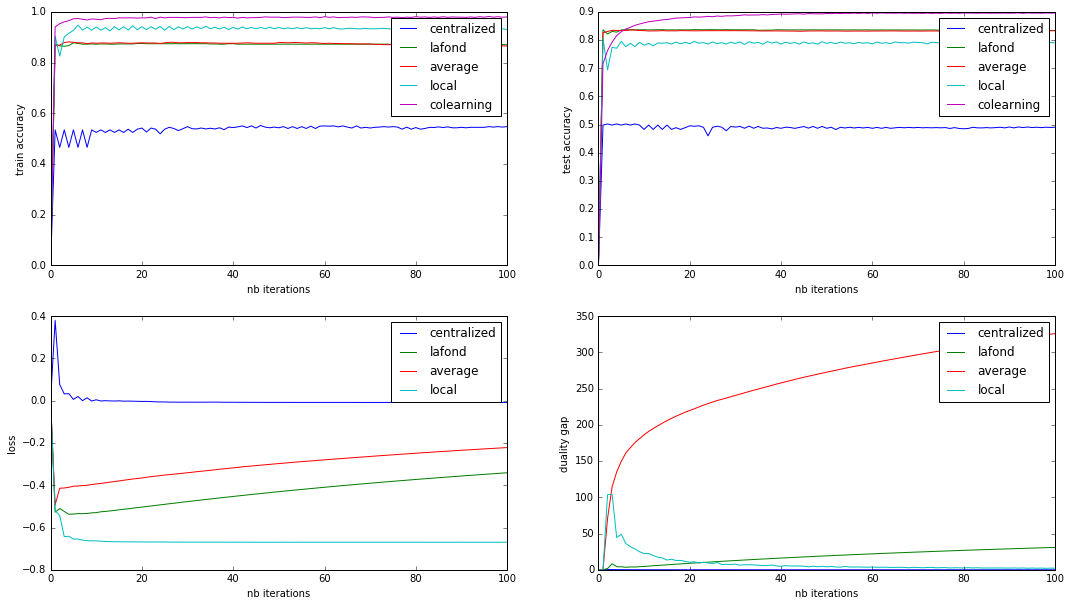

In [19]:
plt.figure(1, figsize=(18, 10))

plt.subplot(221)
plt.xlabel('nb iterations')
plt.ylabel('train accuracy')

for k, r_list in results.items():
    plt.plot(range(len(r_list)), [r['accuracy'][0] for r in r_list], label='{}'.format(k))
plt.legend()

plt.subplot(222)
plt.xlabel('nb iterations')
plt.ylabel('test accuracy')

for k, r_list in results.items():
    plt.plot(range(len(r_list)), [r['accuracy'][1] for r in r_list], label='{}'.format(k))

plt.legend()

plt.subplot(223)
plt.xlabel('nb iterations')
plt.ylabel('loss')

for k, r_list in results.items():
    try:
        plt.plot(range(len(r_list)), [r['loss'] for r in r_list], label='{}'.format(k))
    except:
        pass

plt.legend()

plt.subplot(224)
plt.xlabel('nb iterations')
plt.ylabel('duality gap')

for k, r_list in results.items():
    try:
        plt.plot(range(len(r_list)), [r['duality-gap'] for r in r_list], label='{}'.format(k))
    except:
        pass
    
plt.legend()

- Local policies overfit
- at first iteration, averaging alphas between neighbors improves test accuracy
- keeping on averaging degrades train-test accuracies